In [44]:
%load_ext autoreload
%autoreload 2

import os
import sys
import shutil
import glob
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import seaborn as sns
import tqdm
import npyx
import npyx.corr
from npyx.gl import get_units
from npyx.spk_t import trn
import pandas as pd
from collections import defaultdict
from scipy.signal import savgol_filter
import itertools

# sys.path.append('..')
from utils import ioutils
from utils import figutils
from utils import styleutils
from utils import phy_utils
import configs
import copy

sns.reset_defaults()
styleutils.update_mpl_params(fontsize=10, linewidth=1)
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
mouse = configs.NPIX1
mouse_path = os.path.join(configs.BASE_PATH, mouse.path)
dates = list(mouse.exp_params.keys())

# constants
celltypes_names = [
    'ss',
    '_ss', # cliques
    'cs',
    'mli',
    '>40',
    'rest'
]
celltypes_enforced_rps_dict = {
    'ss': 1,
    'cs': 5,
    'mli': 1,
    '>40': 1,
    '_ss': 1,
    'rest': 1
}
fs = 30000
ccg_win_size = 80 # ms
ccg_bin_size = 1 # ms
ccg_smooth_win = 3 # ms
default_refractory_period = 1 # ms

base_folders = []
phy_folders = []
for date in dates:
    try:
        catgt_folder = glob.glob(os.path.join(mouse_path, date, 'catgt*'))[0]
        catgt_imec_folder = glob.glob(os.path.join(catgt_folder, '*imec0'))[0]
        data_folder = os.path.join(catgt_imec_folder, 'imec0_ks2')
        base_folders.append(os.path.join(mouse_path, date))
        phy_folders.append(data_folder)
    except:
        pass

phy_folders

['D:\\NPIX\\NPIX1\\2023.11.09\\catgt_2023_11_09_s4_g0\\2023_11_09_s4_g0_imec0\\imec0_ks2']

In [46]:
base_folder = base_folders[0]
phy_folder = phy_folders[0]
fig_folder = os.path.join(base_folder, 'FIGURES')
os.makedirs(fig_folder, exist_ok=True)
processed_folder = os.path.join(base_folder, 'PROCESSED')
os.makedirs(processed_folder, exist_ok=True)

In [47]:
# load raw data
spike_clusters = np.load(os.path.join(phy_folder, 'spike_clusters.npy'))
spike_amplitudes = np.load(os.path.join(phy_folder, 'amplitudes.npy'))
spike_times = np.load(os.path.join(phy_folder, 'spike_times.npy')).astype(int)
channel_positions = np.load(os.path.join(phy_folder, 'channel_positions.npy'))
metrics = pd.read_csv(os.path.join(phy_folder, 'metrics.csv'))

# get cluster ids
fn = os.path.join(phy_folder, 'cluster_firing_rate.tsv')
frs = pd.read_csv(fn, delimiter='\t', na_filter=False)
cluster_ids = frs['cluster_id'].to_numpy()

# get cell types
celltypes_fn = os.path.join(phy_folder, 'cluster_cb.tsv')
celltypes_dict = phy_utils.load_phy_tsv_as_dict(celltypes_fn)
celltypes_parcellated_dict = {}
for kw in celltypes_names:
    cd = {}
    for k, v in celltypes_dict.items():
        if kw in v:
            cd[k] = v
    celltypes_parcellated_dict[kw] = cd

# get non cell types
criteria = np.array([
    metrics['firing_rate'] > 2,
    metrics['presence_ratio'] > 0.7,
    metrics['amplitude_cutoff'] < 0.05,
])
good_mask = np.all(criteria, axis=0)
rest = metrics.cluster_id.to_numpy()[good_mask]
rest = [x for x in rest if x not in list(celltypes_dict.keys())]
celltypes_parcellated_dict['rest'] = {k: '' for k in rest}

# get matches
match_fn = os.path.join(phy_folder, 'cluster_match.tsv')
match_dict = phy_utils.load_phy_tsv_as_dict(match_fn)
for k, v in match_dict.items():
    match_dict[k] = int(v)
unique_matches = np.unique(list(match_dict.values()))
n_matches = len(unique_matches)

cs_ss_matches = []
cs_units = list(celltypes_parcellated_dict['cs'].keys())
ss_units = list(celltypes_parcellated_dict['ss'].keys())
for match in unique_matches:
    ss = None
    cs = None
    for unit, cur_match in match_dict.items():
        if cur_match == match:
            if unit in cs_units:
                cs = unit
            if unit in ss_units:
                ss = unit
    assert ss is not None and cs is not None
    cs_ss_matches.append([cs, ss])
cs_ss_matches = np.array(cs_ss_matches)

# get spike trains and amplitudes after deleting duplicates
spike_train_dict = {}
spike_amp_dict = {}
for unit in cluster_ids:
    train = spike_times[spike_clusters==unit]
    amplitudes = spike_amplitudes[spike_clusters==unit]
    duplicates_m = phy_utils.duplicates_mask(train, default_refractory_period, fs)
    spike_train_dict[unit] = train[~duplicates_m].ravel()
    spike_amp_dict[unit] = amplitudes[~duplicates_m].ravel()

for celltype in celltypes_names:
    refractory_period = celltypes_enforced_rps_dict[celltype]
    unit_cluster_ids = list(celltypes_parcellated_dict[celltype].keys())
    for unit in unit_cluster_ids:
        train = spike_times[spike_clusters==unit]
        amplitudes = spike_amplitudes[spike_clusters==unit]
        duplicates_m = phy_utils.duplicates_mask(train, refractory_period, fs)
        spike_train_dict[unit] = train[~duplicates_m].ravel()
        spike_amp_dict[unit] = amplitudes[~duplicates_m].ravel()

# for display
for k, v in celltypes_parcellated_dict.items():
    print(f'{k}: {len(v.keys())}')

ss_cliques = np.unique(list(celltypes_parcellated_dict['_ss'].values()))
print(f'SS cliques: {len(ss_cliques)}')
print(f'N SS-CS matches: {n_matches}')

ss: 10
_ss: 10
cs: 12
mli: 6
>40: 0
rest: 132
SS cliques: 3
N SS-CS matches: 2


Figure saved at: D:\NPIX\NPIX1\2023.11.09\FIGURES\SS_amp_given_CS


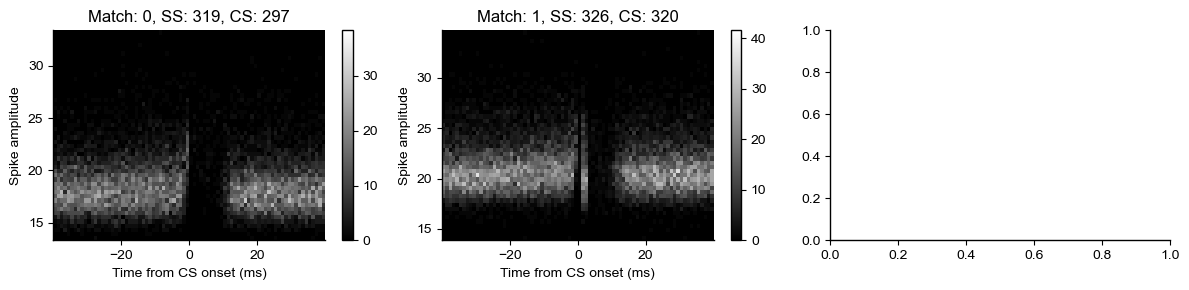

In [48]:
''' Assess if spikelets after CS are low amplitude. Get rid of low amplitude SSs via clustering and see if it gets rid of post-CS peaks in SS firing.

- first plot SS amplitudes and see if it is composed of two distinct clusters. ie see if the distribution of amplitudes is bimodal. then fit with two gaussians and eliminate the other cluster based on determine threshold, and replot CCGs.
THIS IS NOT THE BEST WAY TO DO IT. NOT ALWAYS THE CASE OF CLEAN BIMODALITY OF SPIKE AMPLITUDES

- second, plot amplitudes of SSs before CSs and after SSs. this will confirm whether SS amplitudes after CSs are indeed lower.
'''

bounds = int(ccg_win_size * fs / 1000 // 2)
cols = 3
rows = np.ceil(n_matches/cols).astype(int)
f, axs = figutils.pretty_fig(figsize=(12, rows*3), rows=rows, cols=cols)
for match_ix in range(n_matches):
    cs_unit = cs_ss_matches[match_ix, 0]
    ss_unit = cs_ss_matches[match_ix, 1]
    ss_amplitude = spike_amp_dict[ss_unit]

    cs_train = spike_train_dict[cs_unit].reshape(1, -1)
    ss_train = spike_train_dict[ss_unit].reshape(-1, 1)

    temp = (ss_train - cs_train) # [ss X cs]
    mask = np.logical_and(temp < bounds, temp > -bounds)
    ccg_time = temp[mask]
    ccg_amplitude = [ss_amplitude[x] for x in mask.T]
    ccg_amplitude = np.array(list(itertools.chain(*ccg_amplitude)))

    if rows == 1:
        plt.sca(axs[match_ix])
    else:
        plt.sca(axs[match_ix//cols, match_ix%cols])
    plt.hist2d(x=ccg_time * 1000 / fs, y=ccg_amplitude, bins=(ccg_win_size, 50), cmap='gray', vmin=0, vmax=cs_train.size/ccg_win_size);
    plt.colorbar()
    plt.ylabel('Spike amplitude')
    plt.xlabel('Time from CS onset (ms)')
    plt.title(f'Match: {match_ix}, SS: {ss_unit}, CS: {cs_unit}')
plt.tight_layout()
figutils.save_fig(fig_folder, 'SS_amp_given_CS', transparent=False)

In [49]:
'''Enforcing CS-induced SS pauses.

Note that this operation suffers from circular logic: our requirement for making matches is based of of CS-induced SS pauses. But now we're manually enforcing these pauses to make such matches.

'''
pause_pre_duration = 0.25 # ms
pause_post_duration = 8 # ms

spike_train_dict_mod = copy.deepcopy(spike_train_dict)
spike_amp_dict_mod = copy.deepcopy(spike_amp_dict)
for cs, ss in cs_ss_matches:
    cs_train = spike_train_dict_mod[cs].reshape(1, -1)
    ss_train = spike_train_dict_mod[ss].reshape(-1, 1)
    within_pause_duration_post = (np.uint64(ss_train) - np.uint64(cs_train)) < (fs * pause_post_duration / 1000) # uint ensures that data is between 0 and pause_post_duration
    within_pause_duration_post = within_pause_duration_post.sum(axis=1) > 0
    within_pause_duration_pre = (np.uint64(cs_train) - np.uint64(ss_train)) < (fs * pause_pre_duration / 1000)
    within_pause_duration_pre = within_pause_duration_pre.sum(axis=1) > 0
    within_pause_duration = np.logical_or(within_pause_duration_pre, within_pause_duration_post)

    spike_amp_dict_mod[ss] = spike_amp_dict_mod[ss][~within_pause_duration]
    spike_train_dict_mod[ss] = ss_train.flatten()[~within_pause_duration]
    print(f'N SS discarded / N SS: {np.sum(within_pause_duration) / len(ss_train):0.3f}')

N SS discarded / N SS: 0.001
N SS discarded / N SS: 0.005



--- New spike-sorting detected.
Figure saved at: D:\NPIX\NPIX1\2023.11.09\FIGURES\CS_SS_CCGs_before_vs_after_RPreq


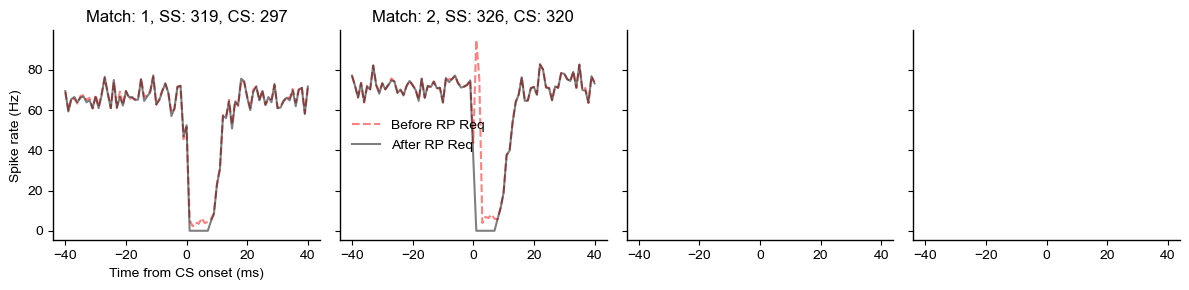

In [50]:
cols = 4
rows = np.ceil(n_matches/cols).astype(int)
f, axs = figutils.pretty_fig(figsize=(12, rows*3), rows=rows, cols=cols, sharex=True, sharey=True)

for i, match_ix in enumerate(unique_matches):
    cs = cs_ss_matches[i, 0]
    ss = cs_ss_matches[i, 1]
    ccgs = npyx.corr.ccg(phy_folder,
                         [-1, -2], # trains override unit indices
                         bin_size=ccg_bin_size,
                         win_size=ccg_win_size,
                         normalize='Hertz',
                         trains=[spike_train_dict_mod[x] for x in [cs, ss]], # trains override unit indices
                         sav=False,
                         again=True
                         )

    ccgs_fake = npyx.corr.ccg(phy_folder,
                         [cs, ss],
                         bin_size=ccg_bin_size,
                         win_size=ccg_win_size,
                         normalize='Hertz',
                         sav=False,
                         again=True
                         )
    if rows == 1:
        plt.sca(axs[i])
    else:
        plt.sca(axs[i//cols, i%cols])
    x = np.arange(0, ccg_bin_size * ccg_win_size + ccg_bin_size, ccg_bin_size) - ccg_win_size // 2
    cc = ccgs_fake[0, 1]. flatten()
    plt.plot(x, cc, alpha=0.5, label='Before RP Req', color='r', linestyle='--')
    cc = ccgs[0, 1]. flatten()
    plt.plot(x, cc, alpha=0.5, label='After RP Req', color='k')
    plt.title(f'Match: {match_ix}, SS: {ss}, CS: {cs}')

    if i == len(unique_matches)-1:
        plt.legend()

    if i == 0:
        plt.xlabel('Time from CS onset (ms)')
        plt.ylabel('Spike rate (Hz)')

plt.tight_layout()
figutils.save_fig(fig_folder, 'CS_SS_CCGs_before_vs_after_RPreq', transparent=False)

In [51]:
package = {}
package['fs'] = fs
package['cluster_ids'] = cluster_ids
package['celltypes_parcellated_dict'] = celltypes_parcellated_dict
package['matches'] = cs_ss_matches
package['spike_trains_dict_after_rp'] = spike_train_dict_mod
package['spike_amp_dict_after_rp'] = spike_amp_dict_mod
package['spike_trains_dict_before_rp'] = spike_train_dict
package['spike_amp_dict_before_rp'] = spike_amp_dict

ioutils.psave(package, os.path.join(processed_folder, 'package'))
print(os.path.join(processed_folder, 'package'))


D:\NPIX\NPIX1\2023.11.09\PROCESSED\package
